In [28]:
import networkx
import math
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn.pytorch import GraphConv

In [29]:
#Loading the karate club graph as a DGL graph
dgl_karate = dgl.DGLGraph(networkx.karate_club_graph())
#Initialising the 5 dimensional features with random values
dgl_karate.ndata['feat'] = torch.randn((34, 5))

In [30]:
#Defing the message and reduce function
#The source node is h and the output is on m
def message_func(edges):
    return {'m' : edges.src['h'] * edges.src['norm']}

reduce_func = fn.sum('m', 'h')

In [31]:
# Define the Graph_Convol module for doing the message passing and giving input features
class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        
    def forward(self, g, inputs):
        #g is the graph and the inputs is the input node features
        #calculating norm
        val_norm = torch.reshape(torch.pow(g.in_degrees(g.nodes()).float(), -0.5), (-1,1))
        g.ndata['norm'] = val_norm
        #Performing linear transformation on the input features
        h = self.linear(inputs)
        #Setting the node features
        g.ndata['h'] = h
        #Doing message passing using the inbuilt message and reduce function
        g.update_all(message_func, reduce_func)
        #Getting the resultant node features and returning them after multiplying by norm value calculated above
        h = g.ndata.pop('h') * val_norm
        return h

In [32]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        #Defining the 2 layers of GCN along with the features size
        self.gcn1 = GraphConv(in_feats, hidden_size)
        self.gcn2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        #Applying Relu activation on the output of first layer before feeding to 2nd layer
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

In [33]:
#Making the initail node features as one-hot encoding using node.eye
inputs = torch.eye(34)
#Assign labels to only instructor i.e. node 0 and president i.e. node 33 initially
labeled_nodes = torch.tensor([0, 33])  
#Assign them the 2 different labels i.e. 0 and 1
labels = torch.tensor([0, 1])
net = GCN(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

all_logits = []
count_epochs = 300
for epoch in range(count_epochs):
    #Getting the vectors of raw i.e. non-normalized prediction probabilities
    logits = net(dgl_karate, inputs)
    #Storing the logits of each epoch in all_logits
    all_logits.append(logits.detach())
    #Applying softmax on the output
    logp = F.log_softmax(logits, 1)
    #As we know labels of only node 0 and 33 so computing loss for them only
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    #Running the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.0689
Epoch 1 | Loss: 1.0664
Epoch 2 | Loss: 1.0639
Epoch 3 | Loss: 1.0615
Epoch 4 | Loss: 1.0590
Epoch 5 | Loss: 1.0566
Epoch 6 | Loss: 1.0541
Epoch 7 | Loss: 1.0517
Epoch 8 | Loss: 1.0493
Epoch 9 | Loss: 1.0469
Epoch 10 | Loss: 1.0445
Epoch 11 | Loss: 1.0421
Epoch 12 | Loss: 1.0397
Epoch 13 | Loss: 1.0373
Epoch 14 | Loss: 1.0349
Epoch 15 | Loss: 1.0325
Epoch 16 | Loss: 1.0302
Epoch 17 | Loss: 1.0278
Epoch 18 | Loss: 1.0254
Epoch 19 | Loss: 1.0231
Epoch 20 | Loss: 1.0208
Epoch 21 | Loss: 1.0184
Epoch 22 | Loss: 1.0161
Epoch 23 | Loss: 1.0138
Epoch 24 | Loss: 1.0114
Epoch 25 | Loss: 1.0091
Epoch 26 | Loss: 1.0068
Epoch 27 | Loss: 1.0045
Epoch 28 | Loss: 1.0023
Epoch 29 | Loss: 1.0000
Epoch 30 | Loss: 0.9977
Epoch 31 | Loss: 0.9954
Epoch 32 | Loss: 0.9932
Epoch 33 | Loss: 0.9909
Epoch 34 | Loss: 0.9886
Epoch 35 | Loss: 0.9863
Epoch 36 | Loss: 0.9841
Epoch 37 | Loss: 0.9818
Epoch 38 | Loss: 0.9794
Epoch 39 | Loss: 0.9771
Epoch 40 | Loss: 0.9748
Epoch 41 | Loss: 0.9724
Ep

Embeddings at epoch 0


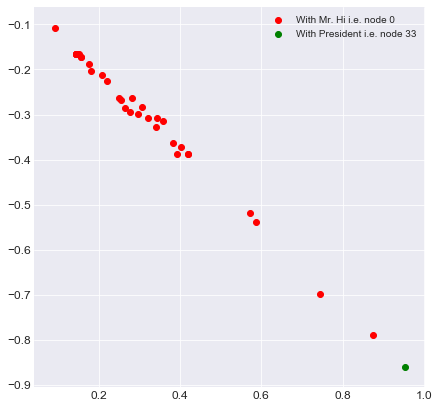

Embeddings at epoch 69


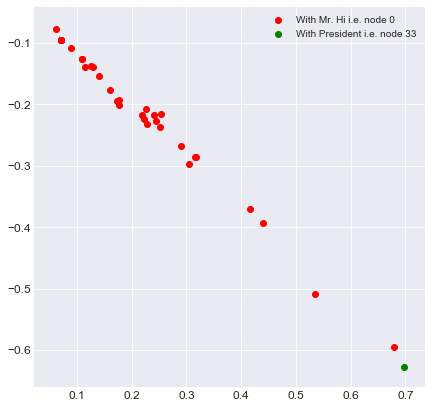

Embeddings at epoch 138


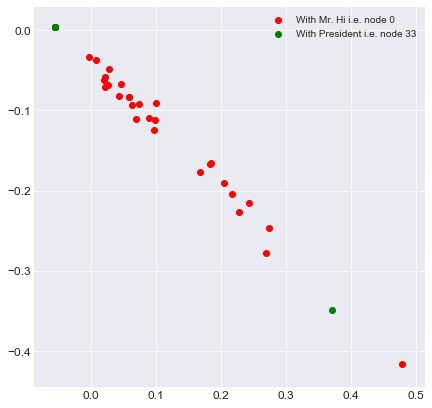

Embeddings at epoch 207


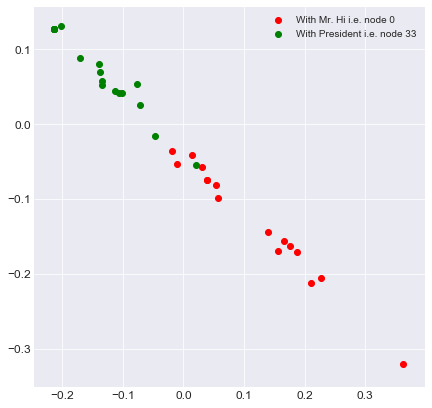

Embeddings at epoch 276


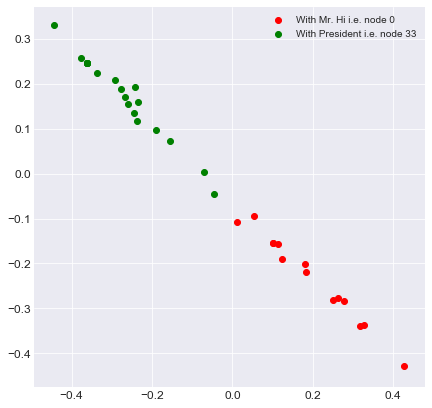

In [34]:
#Now plotting the 2-D embeddings at some epochs
for i in range(0,300, +69):
    #Getting all 2-D embeddings for the particular epoch
    x = all_logits[i]
    x_cord_0 = [float(x[0][0])]
    y_cord_0 = [float(x[0][1])]
    x_cord_33 = [float(x[33][0])]
    y_cord_33 = [float(x[33][1])]
    
    for j in range(1,33):
        a_cord = float(x[j][0])
        b_cord = float(x[j][1])
        #Finding the community to which node belongs according to probabilities
        if a_cord > b_cord:
            x_cord_0.append(a_cord)
            y_cord_0.append(b_cord)
        else:
            x_cord_33.append(a_cord)
            y_cord_33.append(b_cord)
    
    print(f"Embeddings at epoch {i}")
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize = (7,7))
    plt.scatter(x_cord_0, y_cord_0,color = 'r', label='With Mr. Hi i.e. node 0')  
    plt.scatter(x_cord_33, y_cord_33, color = 'g', label='With President i.e. node 33')                               

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend()
    plt.show()

In [35]:
#Finding accuracy of the model
from sklearn.metrics import accuracy_score
temp_karate = networkx.karate_club_graph()
#Preparing a list of ground truth communities of all the nodes
actual_labels = []
for z in range(1,33):
    comm = temp_karate.nodes[z]['club']
    if comm == 'Mr. Hi':
        actual_labels.append(0)
    else:
        actual_labels.append(33)

predicted_labels = []
last_logit = all_logits[count_epochs-1]
for r in range(1,33):
    if float(last_logit[r][0]) > float(last_logit[r][1]):
        predicted_labels.append(0)
    else:
        predicted_labels.append(33)
        
score_acc = accuracy_score(actual_labels, predicted_labels)

In [36]:
print(f"The accuracy of the model in predicting communities = {score_acc}")

The accuracy of the model in predicting communities = 0.9375
